# Chapter 6 – Decision Trees

This notebook contains all the code samples and solutions to the exercises in chapter 6 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (O'Reilly). *Note: all code examples are based on the author's original GitHub repository.*

**Assignment Instructions:**
Per the assignment guidelines, this notebook reproduces the code from Chapter 6. It also includes theoretical explanations and summaries for each concept, as required.

## Chapter Summary

This chapter introduces **Decision Trees**, a versatile and powerful machine learning algorithm capable of performing both classification and regression tasks. Unlike models like SVMs, Decision Trees are intuitive, and their decisions are easy to interpret, making them "white box" models.

Key concepts covered include:
* **Training and Visualization:** How to train a `DecisionTreeClassifier` and visualize the resulting tree structure using `export_graphviz`. [cite: 1077, 1078]
* **Making Predictions:** We trace the path from the root node down to a leaf node to make a prediction. The chapter explains key attributes like `samples`, `value`, and `gini`. [cite: 1079, 1080]
* **Gini Impurity:** This is the cost function used by the CART algorithm. It measures the "purity" of a node. A node is pure (Gini=0) if all instances it applies to belong to the same class. [cite: 1080]
* **Estimating Probabilities:** A Decision Tree can estimate the probability of a class by returning the ratio of training instances of that class in the leaf node the instance falls into. [cite: 1082]
* **The CART Algorithm:** Scikit-Learn uses the Classification and Regression Tree (CART) algorithm, which is a *greedy algorithm* that searches for the feature and threshold that produce the purest subsets. [cite: 1083, 1085]
* **Regularization:** Decision Trees are prone to overfitting if left unconstrained. Regularization is achieved by setting hyperparameters like `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_leaf_nodes`. [cite: 1086, 1087]
* **Regression:** Decision Trees can also perform regression (`DecisionTreeRegressor`). Instead of predicting a class, each node predicts a value, which is the average target value of the training instances in that node. The CART algorithm works similarly but aims to minimize the Mean Squared Error (MSE) instead of impurity. [cite: 1089, 1090]
* **Instability:** The chapter concludes by highlighting a key limitation of Decision Trees: they are very sensitive to small variations in the training data and to data rotation. [cite: 1091]

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 3.7 or later is required for the latest versions of Scikit-Learn), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Training and Visualizing a Decision Tree

### Theoretical Explanation: Training
A Decision Tree is a flowchart-like structure where each internal node represents a test on a feature (e.g., "petal length <= 2.45 cm"), each branch represents the outcome of the test, and each leaf node (or terminal node) holds a class label. [cite: 1079]

The code below trains a `DecisionTreeClassifier` on the Iris dataset. We limit the tree's depth to 2 to keep it simple and easy to visualize. [cite: 1077]

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

### Theoretical Explanation: Visualization
We can visualize the trained Decision Tree by using the `export_graphviz()` method to output a graph definition file (called `iris_tree.dot`). [cite: 1078]

We can then use the `dot` command-line tool (from the Graphviz package) to convert this `.dot` file to a `.png` image or other formats. [cite: 1078]

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

# You can run this in your terminal to convert the .dot file to .png:
# $ dot -Tpng iris_tree.dot -o iris_tree.png

# Or, if you have the graphviz Python library installed:
try:
    import graphviz
    from graphviz import Source

    Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))
except ImportError:
    print("Install graphviz to display the tree, or run the dot command line tool.")

### Theoretical Explanation: Making Predictions

Let’s see how the tree in the figure above makes predictions. [cite: 1079]

1.  **Start at the root node (depth 0):** This node asks whether the flower’s **petal length is ≤ 2.45 cm**. [cite: 1079]
2.  **Case 1 (True):** If it is, you move down to the root’s left child (depth 1, left). This is a **leaf node** (it has no children). It predicts the class `setosa`. [cite: 1079, 1080]
3.  **Case 2 (False):** If the petal length is > 2.45 cm, you move to the root’s right child (depth 1, right). This is not a leaf node, so it asks another question: **is the petal width ≤ 1.75 cm**? [cite: 1080]
4.  **Case 2a (True):** If it is, you move to the right node's left child (depth 2, left). This is a leaf node that predicts `versicolor`. [cite: 1080]
5.  **Case 2b (False):** If it is not, you move to the right node's right child (depth 2, right). This is a leaf node that predicts `virginica`. [cite: 1080]

**Node Attributes:**
* `samples`: Counts how many training instances the node applies to. [cite: 1080]
* `value`: Shows how many training instances of each class this node applies to. [cite: 1080]
* `gini`: Measures the node's **impurity**. A node is "pure" (gini=0) if all its instances belong to the same class. The formula is: [cite: 1080]
    $$G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$$
    where $p_{i,k}$ is the ratio of class *k* instances among the training instances in the $i$-th node. [cite: 1080]

## Estimating Class Probabilities

### Theoretical Explanation
A Decision Tree can also estimate the probability that an instance belongs to a particular class *k*. It first finds the leaf node for the instance, then it returns the ratio of training instances of class *k* in that node. [cite: 1082]

For example, if a flower has petals 5 cm long and 1.5 cm wide, it falls into the depth-2 left node (petal length > 2.45 cm, petal width ≤ 1.75 cm). This node's `value` is `[0, 49, 5]`. [cite: 1082]
So, it will output the following probabilities: [cite: 1082]
* Iris-Setosa: 0/54 (0%)
* Iris-Versicolor: 49/54 (90.7%)
* Iris-Virginica: 5/54 (9.3%)

The predicted class is the one with the highest probability (Iris-Versicolor). [cite: 1082]

In [4]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [5]:
tree_clf.predict([[5, 1.5]])

array([1])

## The CART Training Algorithm

### Theoretical Explanation

Scikit-Learn uses the **Classification and Regression Tree (CART)** algorithm to train Decision Trees. [cite: 1083]

1.  **Splitting:** The algorithm first splits the training set into two subsets using a single feature *k* and a threshold *t_k* (e.g., "petal length ≤ 2.45 cm"). [cite: 1083]
2.  **Choosing *k* and *t_k*:** How does it choose? It searches for the pair (*k*, *t_k*) that produces the **purest subsets** (weighted by their size). It tries to minimize this cost function: [cite: 1083]

    $$J(k, t_k) = \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}}$$
    
    * $G_{\text{left/right}}$ is the impurity (e.g., Gini) of the left/right subset. [cite: 1083]
    * $m_{\text{left/right}}$ is the number of instances in the left/right subset. [cite: 1083]

3.  **Recursion:** Once the set is split, the algorithm splits the subsets using the same logic, then the sub-subsets, and so on, recursively. [cite: 1083]
4.  **Stopping:** It stops recursing when it reaches the maximum depth (`max_depth`) or if it cannot find a split that will reduce impurity. Other hyperparameters like `min_samples_split` and `min_samples_leaf` also control stopping. [cite: 1083]

The CART algorithm is a **greedy algorithm**: it greedily searches for the best split at the current level and repeats. It does not check if this split will lead to the best possible tree several levels down. [cite: 1085]

## Regularization Hyperparameters

### Theoretical Explanation

Decision Trees make very few assumptions about the training data. If left unconstrained, the tree will adapt itself very closely to the training data, which leads to **overfitting**. [cite: 1086]

To avoid overfitting, we must restrict the Decision Tree’s freedom. This is done using regularization hyperparameters. [cite: 1086]

The `DecisionTreeClassifier` class has several parameters to control this: [cite: 1086]
* `max_depth`: The maximum depth of the tree. Reducing this will regularize the model. [cite: 1086]
* `min_samples_split`: The minimum number of samples a node must have *before* it can be split. [cite: 1086]
* `min_samples_leaf`: The minimum number of samples a *leaf* node must have. [cite: 1086]
* `max_leaf_nodes`: The maximum number of leaf nodes. [cite: 1087]
* `max_features`: The maximum number of features that are evaluated for splitting at each node. [cite: 1087]

**Increasing `min_*` or decreasing `max_*` hyperparameters will regularize the model.** [cite: 1087]

In [7]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


Saving figure min_samples_leaf_plot


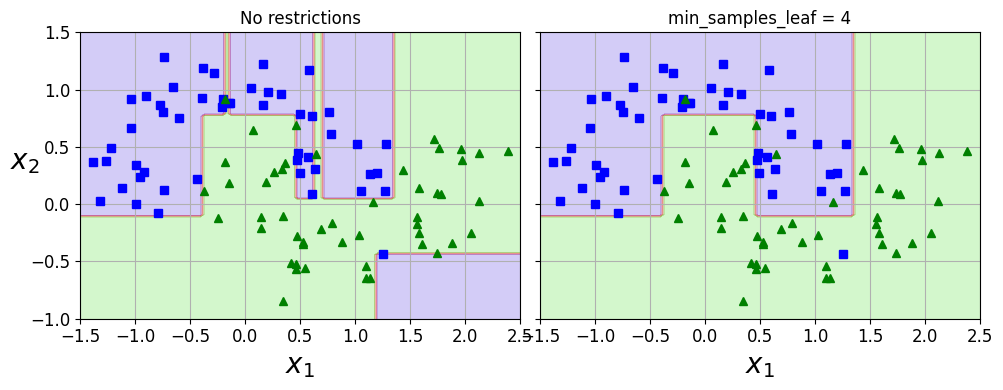

In [8]:
# Code example: Regularization using min_samples_leaf
from sklearn.datasets import make_moons

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_predictions(deep_tree_clf1, [-1.5, 2.5, -1, 1.5])
plot_dataset(Xm, ym, [-1.5, 2.5, -1, 1.5])
plt.title("No restrictions")

plt.sca(axes[1])
plot_predictions(deep_tree_clf2, [-1.5, 2.5, -1, 1.5])
plot_dataset(Xm, ym, [-1.5, 2.5, -1, 1.5])
plt.title("min_samples_leaf = 4")
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

The plot on the left (no restrictions) is clearly overfitting. The plot on the right (`min_samples_leaf=4`) shows a model that will likely generalize much better. [cite: 1088]

## Regression

### Theoretical Explanation

Decision Trees can also perform regression tasks using the `DecisionTreeRegressor` class. [cite: 1089]

The main difference is that instead of predicting a class in each node, it **predicts a value**. The predicted value for a leaf node is the **average target value** of the training instances in that node. [cite: 1089]

The CART algorithm works similarly, but instead of minimizing impurity, it now tries to split the training set to **minimize the MSE** (Mean Squared Error). [cite: 1090]

The cost function to minimize is:
$$J(k, t_k) = \frac{m_{\text{left}}}{m}\text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m}\text{MSE}_{\text{right}}$$

Just like for classification, Decision Tree regressors are prone to overfitting. [cite: 1090]

Saving figure tree_regression_plot


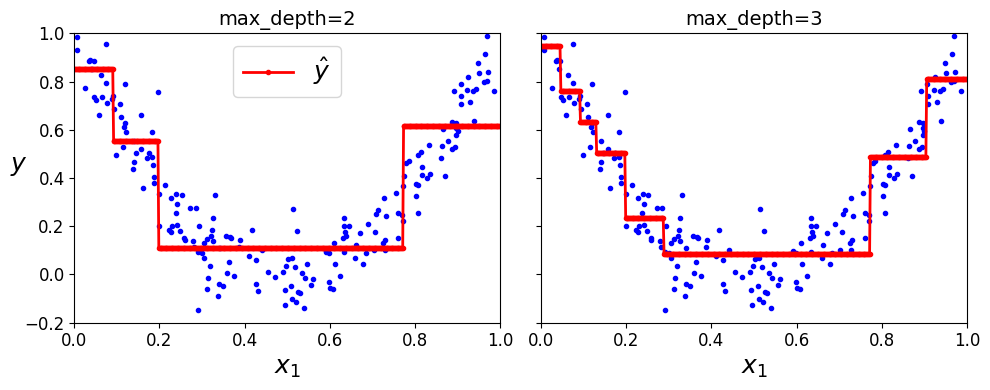

In [10]:
from sklearn.tree import DecisionTreeRegressor

# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5)**2
y = y + np.random.randn(m, 1) / 10

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

# Helper function to plot the regression predictions
def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$") # Changed 'r.-W' to 'r.-'

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
plt.title("max_depth=2", fontsize=14)
plt.legend(loc="upper center", fontsize=18)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

Saving figure tree_regression_regularization_plot


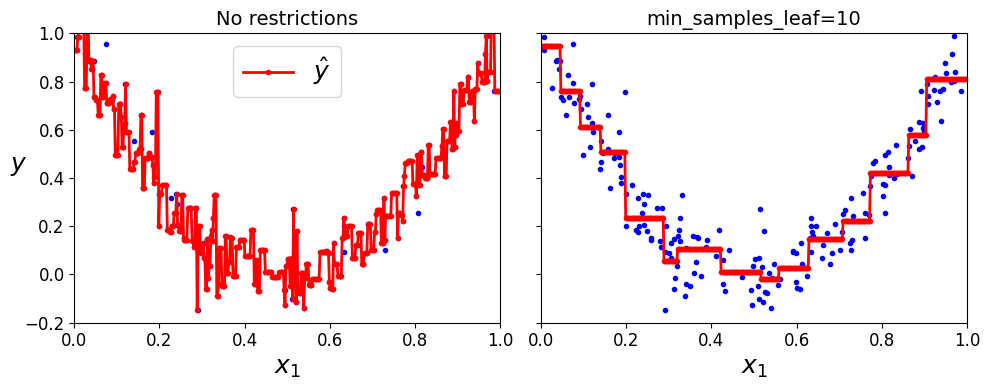

In [11]:
# Example of an unregularized (overfitting) regression tree
tree_reg_overfit = DecisionTreeRegressor(random_state=42)
tree_reg_regularized = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg_overfit.fit(X, y)
tree_reg_regularized.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg_overfit, X, y)
plt.title("No restrictions", fontsize=14)
plt.legend(loc="upper center", fontsize=18)

plt.sca(axes[1])
plot_regression_predictions(tree_reg_regularized, X, y, ylabel=None)
plt.title("min_samples_leaf=10", fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

The plot on the left is overfitting badly. The plot on the right (`min_samples_leaf=10`) is a much more reasonable model. [cite: 1090]

## Instability

### Theoretical Explanation

Decision Trees have a few limitations.

1.  **Sensitivity to Rotation:** They love orthogonal decision boundaries ( perpendicular to an axis). This makes them sensitive to training set rotation. The code below shows how a simple 45° rotation makes the decision boundary unnecessarily convoluted. [cite: 1091]
2.  **Sensitivity to Small Variations:** More generally, Decision Trees are very sensitive to small variations in the training data. For example, removing one instance can sometimes lead to a completely different tree being trained. [cite: 1091]

**Random Forests** (covered in Chapter 7) can limit this instability by averaging predictions over many trees. [cite: 1092]

Saving figure sensitivity_to_rotation_plot


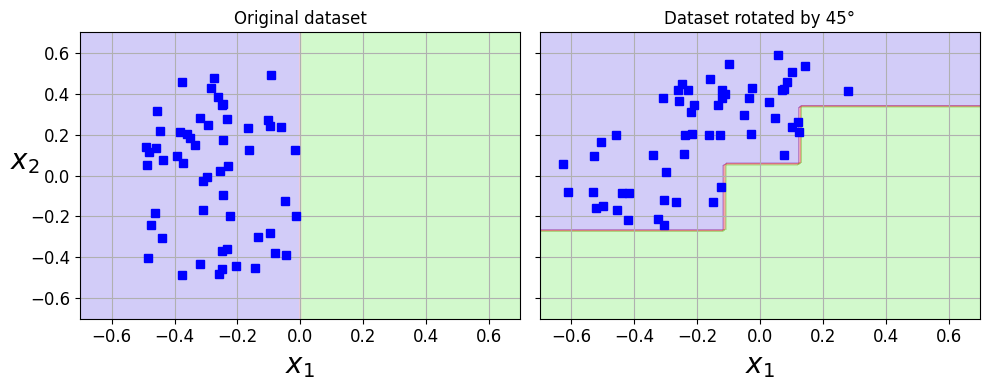

In [12]:
# Sensitivity to rotation
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_predictions(tree_clf_s, [-0.7, 0.7, -0.7, 0.7])
plot_dataset(Xs, ys, [-0.7, 0.7, -0.7, 0.7])
plt.title("Original dataset")

plt.sca(axes[1])
plot_predictions(tree_clf_sr, [-0.7, 0.7, -0.7, 0.7])
plot_dataset(Xsr, ys, [-0.7, 0.7, -0.7, 0.7])
plt.title("Dataset rotated by 45°")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

## Exercises

From Chapter 6, page 186:

1.  What is the approximate depth of a Decision Tree trained (without restrictions) on a training set with one million instances?
2.  Is a node’s Gini impurity generally lower or greater than its parent’s? Is it *generally* lower/greater, or *always* lower/greater?
3.  If a Decision Tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?
4.  If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?
5.  If it takes one hour to train a Decision Tree on a training set containing 1 million instances, roughly how much time will it take to train another Decision Tree on a training set containing 10 million instances?
6.  If your training set contains 100,000 instances, will setting `presort=True` speed up training?
7.  Train and fine-tune a Decision Tree for the moons dataset (e.g., using `make_moons(n_samples=10000, noise=0.4)`).
8.  Grow a forest (an ensemble of Decision Trees) on the moons dataset.